In [1]:
import json
from itertools import islice
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#https://medium.com/@m_vemuri/create-a-geographic-heat-map-of-the-city-of-toronto-in-python-cd2ae0f8be55
import geopandas as gpd
from geopandas.tools import sjoin

/opt/homebrew/anaconda3/envs/cls/lib/python3.10/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.9.1dev-CAPI-1.14.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [48]:
mad_map = gpd.read_file('/Users/willstedden/Downloads/acs2021_5yr_B08201_14000US55025011407/acs2021_5yr_B08201_14000US55025011407.geojson')
mad_pop = gpd.read_file('/Users/willstedden/Downloads/acs2021_5yr_B01003_14000US55025011407/acs2021_5yr_B01003_14000US55025011407.geojson')
metada = json.load(open('/Users/willstedden/Downloads/acs2021_5yr_B08201_14000US55025011407/metadata.json'))

In [49]:
mad_map = mad_map.merge(mad_pop[['name','B01003001']],how='left',on='name')

In [51]:
mad_map['overuse_total']= \
    mad_map['B08201011']+2*mad_map['B08201011']+3*mad_map['B08201012']+ \
    mad_map['B08201017']+2*mad_map['B08201018']+ \
    mad_map['B08201024']
mad_map['pop'] = mad_map['B01003001']
mad_map['overuse_rate'] = mad_map['overuse_total']/mad_map['pop']

<AxesSubplot: >

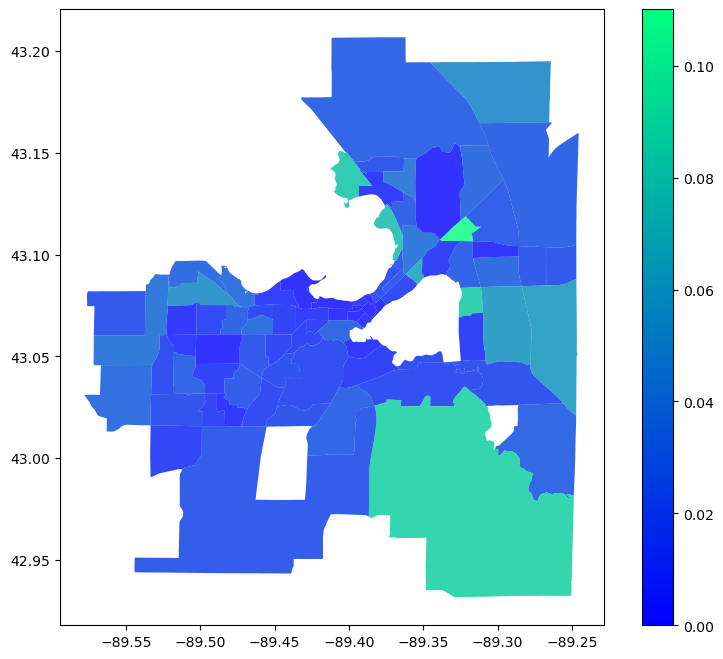

In [52]:
fig, ax = plt.subplots(figsize=(10,8))

mad_map.loc[(mad_map['B08201001']>0) & (mad_map['B08201001']<10000)].plot(column="overuse_rate",ax=ax,alpha=0.8,cmap='winter',legend=True)


In [53]:
metada

{'release': {'id': 'acs2021_5yr',
  'years': '2017-2021',
  'name': 'ACS 2021 5-year'},
 'tables': {'B08201': {'title': 'Household Size by Vehicles Available',
   'universe': 'Households',
   'denominator_column_id': 'B08201001',
   'columns': {'B08201001': {'name': 'Total:', 'indent': 0},
    'B08201002': {'name': 'No vehicle available', 'indent': 1},
    'B08201003': {'name': '1 vehicle available', 'indent': 1},
    'B08201004': {'name': '2 vehicles available', 'indent': 1},
    'B08201005': {'name': '3 vehicles available', 'indent': 1},
    'B08201006': {'name': '4 or more vehicles available', 'indent': 1},
    'B08201007': {'name': '1-person household:', 'indent': 1},
    'B08201008': {'name': 'No vehicle available', 'indent': 2},
    'B08201009': {'name': '1 vehicle available', 'indent': 2},
    'B08201010': {'name': '2 vehicles available', 'indent': 2},
    'B08201011': {'name': '3 vehicles available', 'indent': 2},
    'B08201012': {'name': '4 or more vehicles available', 'inden

In [54]:
mad_trans = gpd.read_file('/Users/willstedden/Downloads/Metro_Transit_Ridership_by_Stop.geojson')

In [55]:
mymap = sjoin(mad_trans,mad_map.loc[(mad_map['B08201001']>0) & (mad_map['B08201001']<10000)], how='left')

In [56]:
map2 = mad_map.merge(mymap.groupby('name')['Weekday'].sum().reset_index(),how='left')

In [59]:
map2['Weekday_normed']=np.log(map2['Weekday']/map2['pop'])

In [61]:
brt = gpd.read_file('/Users/willstedden/Downloads/Bus_Rapid_Transit_System_Lines.geojson')
brt.head()

,OBJECTID,Type,Comments,Corridor,Notes,LPA,SHAPESTLength,geometry
0,1,main,None,C,None,3,5884.251504,"LINESTRING (-89.38210 43.07614, -89.38122 43.0..."
1,2,main,None,C,None,1,3292.955598,"LINESTRING (-89.40062 43.07329, -89.40215 43.0..."
2,3,main,None,W,None,1,20640.279196,"LINESTRING (-89.41293 43.07356, -89.41329 43.0..."
3,4,main,None,E,None,1,19033.613315,"LINESTRING (-89.34871 43.10036, -89.34791 43.1..."
4,5,main,None,S,None,2,15851.380171,"LINESTRING (-89.39404 43.03846, -89.39533 43.0..."


<AxesSubplot: >

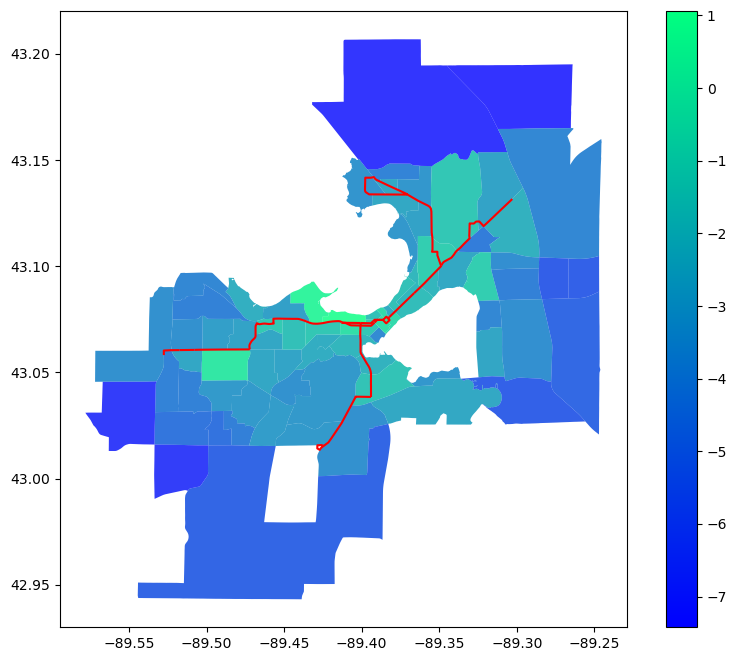

In [63]:
fig, ax = plt.subplots(figsize=(10,8))
map2.plot(column="Weekday_normed",ax=ax,alpha=0.8,cmap='winter',legend=True)
brt.plot(ax=ax,color='red')